In [1]:
import math as math
import matplotlib.pyplot as plt
import numpy as np
import csv
import lmfit
from scipy import stats

In [4]:
#Lets try to understand how good the fits we made in last class are, lets load the supernova data again
label='sn_z_mu_dmu_plow_union2.1.txt'
def distanceconv(iMu):
    power=iMu/5+1
    return 10**power

def distanceconverr(iMu,iMuErr):
    power=iMu/5+1
    const=math.log(10)/5.
    return const*(10**power)*iMuErr

redshift=np.array([])
distance=np.array([])
distance_err=np.array([])
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    for row in plots:
        if float(row[1]) > 0.1:
            continue
        redshift = np.append(redshift,float(row[1]))
        distance = np.append(distance,distanceconv(float(row[2])))
        distance_err = np.append(distance_err,distanceconverr(float(row[2]),float(row[3])))

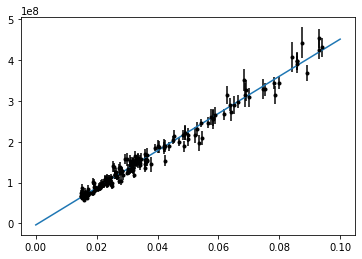

Hubbles Constant: 65.87381819553848 +/- 0.722443335496389 intercept -3931446.778206587 +/- 2047227.7501262664


In [5]:
#Lets fit this to a linear function by hand
#from the derivation we have 
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

def linear(ix,ia,ib):
    return ia*ix+ib

var=variance(redshift)
cov=covariance(redshift,distance)
slope=cov/var
const=distance.mean()-slope*redshift.mean()
xvals = np.linspace(0,0.1,100)
yvals = []
for pX in xvals:
    yvals.append(linear(pX,slope,const))

plt.plot(xvals,yvals)
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.show()
#Now to compute the uncertainty
residuals=np.array([])
for i0 in range(len(redshift)):
    pResid=linear(redshift[i0],slope,const)-distance[i0]
    residuals = np.append(residuals,pResid**2)
slopeunc=np.sum(residuals)/(len(redshift)-2)*1./variance(redshift)*1./len(redshift)
shiftunc=slopeunc*(redshift.mean())**2+np.sum(residuals)/(len(redshift)-2)/len(redshift)
print("Hubbles Constant:",1e6*3e5/slope,"+/-",1e6*3e5*math.sqrt(slopeunc)/slope/slope,"intercept",const,"+/-",math.sqrt(shiftunc))#Note 1e6 is from pc to Mpc and 3e5 is c in km/s



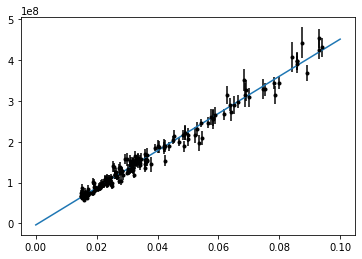

Hubbles Constant: 66.84173202572255 +/- 0.8191821416610308 intercept -5198636.570725098 +/- 1462132.4883225367


In [6]:
weights=np.array([])
for pVal in distance_err:
    weights = np.append(weights,1./pVal/pVal)

#Now lets do it with weights
def variance_w(isamples,iweights):
    mean=np.average(isamples,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(isamples)):
        tot+=iweights[i0]*(isamples[i0]-mean)**2
    return tot/sumw

def covariance_w(ixs,iys,iweights):
    meanx=np.average(ixs,weights=iweights)
    meany=np.average(iys,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(ixs)):
        tot+=iweights[i0]*(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/sumw


varw=variance_w(redshift,weights)
covw=covariance_w(redshift,distance,weights)
slopew=covw/varw
constw=np.average(distance,weights=weights)-slope*np.average(redshift,weights=weights)
yvalsw = []
for pX in xvals:
    yvalsw.append(linear(pX,slope,const))

sumw=np.sum(weights)
rsw=np.average(redshift,weights=weights)
residualsw=np.array([])
for i0 in range(len(redshift)):
    pResid=linear(redshift[i0],slopew,constw)-distance[i0]
    residualsw = np.append(residualsw,weights[i0]*pResid**2)
sigmaw=np.sum(residualsw)/(len(redshift)-2)
slopeuncw=sigmaw*1./variance_w(redshift,weights)*1./sumw
shiftuncw=slopeunc*(rsw)**2+sigmaw/sumw

    
plt.plot(xvals,yvalsw)
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.show()
print("Hubbles Constant:",1e6*3e5/slopew,"+/-",1e6*3e5*math.sqrt(slopeuncw)/slope/slope,"intercept",constw,"+/-",math.sqrt(shiftuncw))#Note 1e6 is from pc to Mpc and 3e5 is c in km/s


In [7]:
#Now lets do the same thing with standard python tools
slope, intercept, r_value, p_value, std_err = stats.linregress(redshift,distance)
print("Hubbles Constant:",1e6*3e5/slope,"intercept",intercept)

#now with weights
from sklearn.linear_model import LinearRegression
redshifthack=np.reshape(redshift,(175,1))
model.fit(redshifthack,distance,weights)
slope=model.coef_
const=model.intercept_
print("Hubbles Constant:",1e6*3e5/slope,"intercept",const)


Hubbles Constant: 65.87381819553848 intercept -3931446.778206587


NameError: name 'model' is not defined

     fun: -803.3955308825884
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663


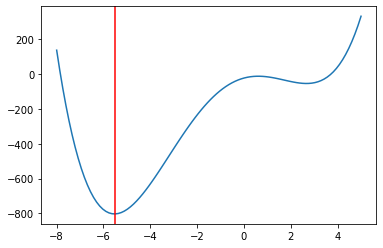

In [8]:
#Now lets do this with a general tool that optimizes
from scipy import optimize as opt
#First lets see what it does
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1
sol=opt.minimize_scalar(f, method='Brent')
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
print(sol)

In [9]:
#great it finds the minimum of a function lets take a fancier tool based on this
from scipy.optimize import curve_fit
def f(x,a,b):
    return a*x+b
popt, pcov = curve_fit(f, redshift,distance)
perr = np.sqrt(np.diag(pcov))
print("Hubbles Constant:",1e6*3e5/popt[0],"+/-",(1e6*3e5/popt[0]/popt[0])*perr[0],"intercept",popt[1],"+/-",perr[1])

#Now lets do it with weights
popt, pcov = curve_fit(f, redshift,distance,sigma=distance_err)
perr = np.sqrt(np.diag(pcov))
print("Hubbles Constant:",1e6*3e5/popt[0],"+/-",(1e6*3e5/popt[0]/popt[0])*perr[0],"intercept",popt[1],"+/-",perr[1])


Hubbles Constant: 65.87381783782733 +/- 0.7224431434183997 intercept -3931447.9363341173 +/- 2047227.4423644692
Hubbles Constant: 66.84173200500216 +/- 0.828875930376245 intercept -3501821.4128609835 +/- 1587584.3707810396


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 175
    # variables        = 2
    chi-square         = 164.545562
    reduced chi-square = 0.95113042
    Akaike info crit   = -6.77973219
    Bayesian info crit = -0.45016025
[[Variables]]
    a:  4.4882e+09 +/- 55656415.0 (1.24%) (init = 1e+10)
    b: -3501821.34 +/- 1587583.80 (45.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.902
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 175
    # variables        = 2
    chi-square         = 164.545562
    reduced chi-square = 0.95113042
    Akaike info crit   = -6.77973219
    Bayesian info crit = -0.45016025
[[Variables]]
    a:  66.8417318 +/- 0.82887580 (1.24%) (init = 70)
    b: -3501821.84 +/- 1587584.06 (45.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.902


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

<Figure size 432x288 with 0 Axes>

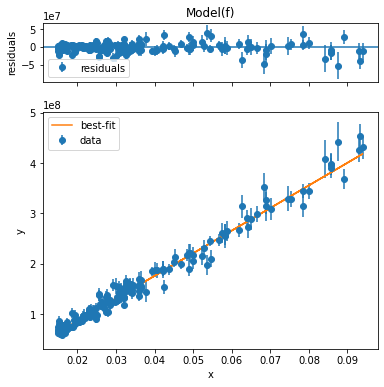

<Figure size 432x288 with 0 Axes>

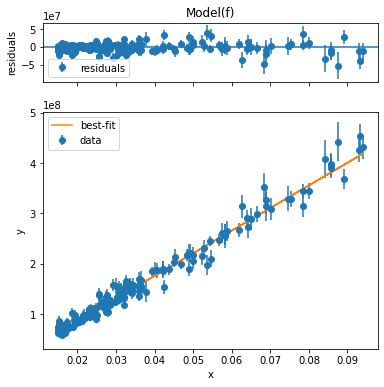

In [10]:
#Now lets use lmfit for completeness
model  = lmfit.Model(f)
p = model.make_params(a=1e10,b=0)
weights=np.array([])
for pVal in distance_err:
    weights = np.append(weights,1./pVal)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot()

#Now because I am tired of these transforms
def f(x,a,b):
    return (1e6*3e5/a)*x+b
model  = lmfit.Model(f)
p = model.make_params(a=70,b=0)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot()

In [11]:
#Ok now that we have upgraded tools, lets fit some more data
redshift=np.array([])
distance=np.array([])
distance_err=np.array([])
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    for row in plots:
        redshift = np.append(redshift,float(row[1]))
        distance = np.append(distance,distanceconv(float(row[2])))
        distance_err = np.append(distance_err,distanceconverr(float(row[2]),float(row[3])))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 580
    # variables        = 2
    chi-square         = 1192.37950
    reduced chi-square = 2.06294032
    Akaike info crit   = 421.993280
    Bayesian info crit = 430.719336
[[Variables]]
    a:  57.5408692 +/- 0.35372688 (0.61%) (init = 70)
    b: -22711293.5 +/- 1375350.40 (6.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.689


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

<Figure size 432x288 with 0 Axes>

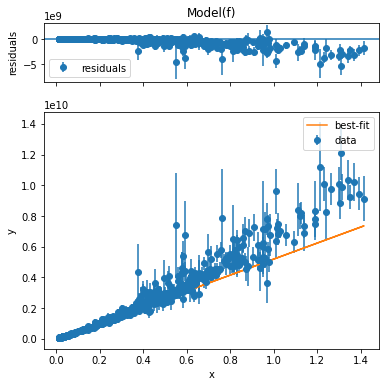

In [12]:
#First lets try a linear fit
def f(x,a,b):
    return (1e6*3e5/a)*x+b
weights=np.array([])
for pVal in distance_err:
    weights = np.append(weights,1./pVal)
model  = lmfit.Model(f)
p = model.make_params(a=70,b=0)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 580
    # variables        = 2
    chi-square         = 562.802647
    reduced chi-square = 0.97370700
    Akaike info crit   = -13.4574630
    Bayesian info crit = -4.73140683
[[Variables]]
    h0:  69.1826498 +/- 0.34566990 (0.50%) (init = 50)
    q:  -0.13475666 +/- 0.03650516 (27.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(h0, q) = -0.756


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

<Figure size 432x288 with 0 Axes>

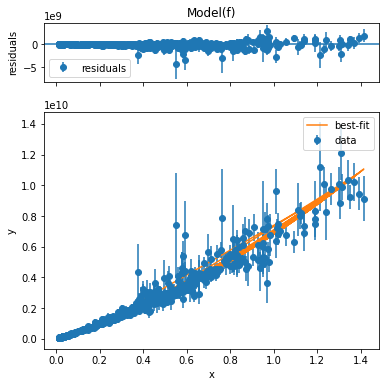

In [13]:
#Clearly thats not working so lets use an approximation to this
def f(x,h0,q):
    val=x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)
    return val
model  = lmfit.Model(f)
p = model.make_params(h0=50,q=0)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot()

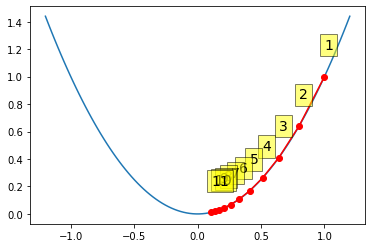

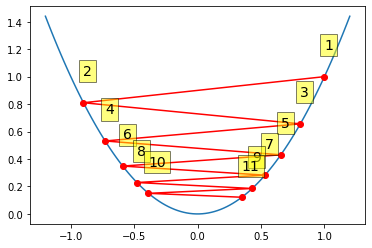

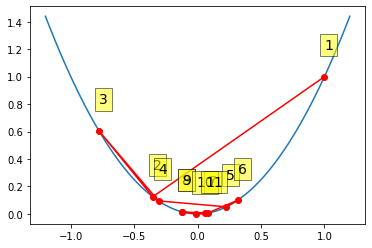

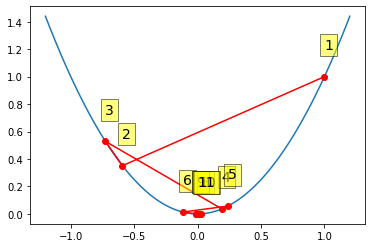

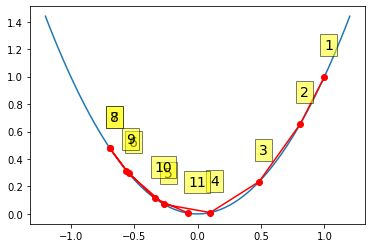

In [14]:
def f(x):
    return x**2
def grad(x):
    return 2*x
#now we are going to move from x in timestesps alpha
def gd(x, grad, alpha, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1] = x
    return xs

#Now will update both momentum and velocity in timesteps alpha but with a dilution factor of beta
def gd_momentum_true(x, grad, alpha,beta=1.0, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    v = 0
    for i in range(max_iter):
        v = v - alpha*grad(x)
        damp = 1/(1+beta**(i+1))
        x = x + damp*(alpha * v  - 0.5 * alpha * alpha*grad(x))
        xs[i+1] = x
    return xs

#Now will update both momentum and velocity in timesteps alpha but with a dilution factor of beta
def gd_momentum(x, grad, alpha, beta=0.9, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)
        vc = v/(1+beta**(i+1))
        x = x - alpha * v
        xs[i+1] = x
    return xs

alpha = 0.1
x0 = 1
xs = gd(x0, grad, alpha)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i,bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
plt.show()    

#and for large alpha 
alpha = 0.95
x0 = 1
xs = gd(x0, grad, alpha)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i,bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
plt.show()
    
#Now we do it with momentum  and no damping
xs = gd_momentum_true(x0, grad, alpha=0.95,beta=1.0)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i,bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
plt.show()    

#Now we do it with momentum  and  damping
xs = gd_momentum_true(x0, grad, alpha=0.95,beta=0.7)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i,bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
plt.show()    


#Now we remove the quadratic term
xs = gd_momentum(x0, grad, alpha=0.95,beta=0.9)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i,bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
plt.show()    

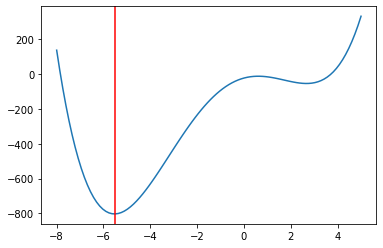

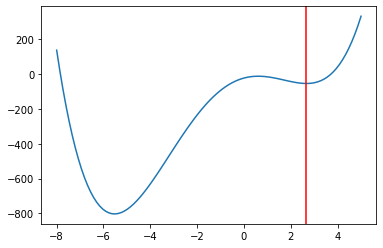

In [15]:
#Now lets do this with a general tool that optimizes
import scipy.linalg as la
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

def fprime(x):
    return 4*x**3 + 9*(x-2)**2 - 30*(x)

def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the function above."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * fprime(bestx)
        bestx = bestx - step

        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,nfev=funcalls, success=(niter > 1))

def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

#from scipy.optimize import check_grad
#for x in np.random.uniform(-2,2,10):
#print(x, check_grad(f,fprime, x))
    
x0 = np.array([-7])
ps = [x0]
sol=opt.minimize(f, x0, method=custmin, callback=reporter)
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
plt.show()

#Now lets trick it
x0 = np.array([5])
ps = [x0]
sol=opt.minimize(f, x0, method=custmin, callback=reporter)
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')

In [16]:
#Note that since we are fitting two parameters we need to do this in 2D
def f(x,h0,q):
    val=x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)
    return val

def fprime(x,h0,q):
    der=np.zeros(2)
    der[0]=-1*x*(1e6*3e5/h0/h0)*(1 + ((1-q)*0.5)*x)
    der[1]=x*(1e6*3e5/h0)*(-0.5*x)
    return der

def algof(inputs):
    d=0
    for i0 in range(len(redshift)):
        yhat=f(redshift[i0],inputs[0],inputs[1])
        pD=(distance[i0]-yhat)**2
        #pD=pD/dmean
        d+=pD*weights[i0]*weights[i0]
    return d

def algofprime(inputs):
    d=np.zeros(2)
    for i0 in range(len(redshift)):
        yhat=f(redshift[i0],inputs[0],inputs[1])
        pD=2*(distance[i0]-yhat)
        yhatprime=fprime(redshift[i0],inputs[0],inputs[1])
        #print(yhatprime,pD,d)
        #pD=pD/dmean
        d=d+(yhatprime*pD)*weights[i0]*weights[i0]
    return d

def custmin(fun, x0, args=(), maxfev=None, alpha=0.0001,maxiter=10000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the function above."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        if niter % 1000 == 0: 
            print(niter,bestx)
        # the next 2 lines are gradient descent
        step = alpha * algofprime(bestx)
        #print(bestx,step)
        bestx = bestx + step

        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,nfev=funcalls, success=(niter > 1))

def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

#tmp=algofprime([70,0.03])
x0 = np.array([40,0])
ps = [x0]
sol0=opt.minimize(algof, x0, method=custmin, callback=reporter)
print(sol0)

sol1=opt.minimize(algof, x0)#, method=custmin, callback=reporter)
print(sol1)

1000 [6.69028678e+01 4.81898374e-02]
2000 [68.76621661 -0.10134347]
3000 [69.10148541 -0.12824444]
4000 [69.16664465 -0.13347248]
5000 [69.17948648 -0.13450283]
6000 [69.18202428 -0.13470645]
7000 [69.18252607 -0.13474671]
8000 [69.1826253  -0.13475468]
9000 [69.18264492 -0.13475625]
10000 [69.1826488  -0.13475656]
     fun: 562.8026474723382
    nfev: 10001
     nit: 10000
 success: True
       x: array([69.1826488 , -0.13475656])
      fun: 562.8026474723395
 hess_inv: array([[0.00167088, 0.00057099],
       [0.00057099, 0.00024205]])
      jac: array([7.62939453e-06, 6.86645508e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 89
      nit: 17
     njev: 22
   status: 2
  success: False
        x: array([69.18265074, -0.1347567 ])


2838689546.13418
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 580
    # variables        = 2
    chi-square         = 539.905260
    reduced chi-square = 0.93409215
    Akaike info crit   = -37.5479659
    Bayesian info crit = -28.8219097
[[Variables]]
    h0:  70.4234336 +/- 0.33558097 (0.48%) (init = 70)
    Om:  0.30136873 +/- 0.01982370 (6.58%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(h0, Om) = -0.741


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

<Figure size 432x288 with 0 Axes>

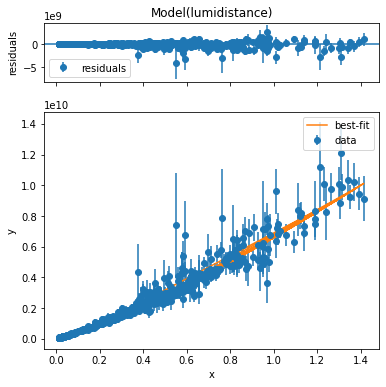

In [17]:
#Now finally lets use the full form 
#You can read this https://en.wikipedia.org/wiki/Distance_measures_(cosmology)
def hubble(z,Om):
    pVal=Om*(1+z)**3+(1.-Om)
    return np.sqrt(pVal)

def lumidistance(x,h0,Om):
    #steps = np.linspace(0.,x,num=nsteps)
    integral=0
    for i0 in range(100):
        pVal=1./hubble(x*float(i0)/100.,Om)
        integral += pVal*x/100.
    d=(1+x)*integral*(1e6*3e5/h0)
    return d

print(lumidistance(0.5,70,0.3))
model  = lmfit.Model(lumidistance)
p = model.make_params(h0=70,Om=0.2)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot()

In [18]:
label='sn_z_mu_dmu_plow_union2.1.txt'
def distanceconv(iMu):
    power=iMu/5+1
    return 10**power

def distanceconverr(iMu,iMuErr):
    power=iMu/5+1
    const=math.log(10)/5.
    return const*(10**power)*iMuErr

redshift=np.array([])
distance=np.array([])
distance_err=np.array([])
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    for row in plots:
        if float(row[1]) > 0.1:
            continue
        redshift = np.append(redshift,float(row[1]))
        distance = np.append(distance,distanceconv(float(row[2])))
        distance_err = np.append(distance_err,distanceconverr(float(row[2]),float(row[3])))


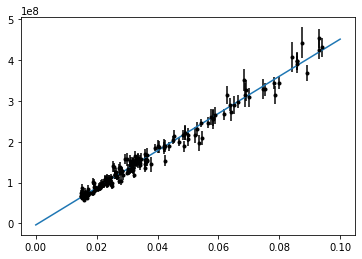

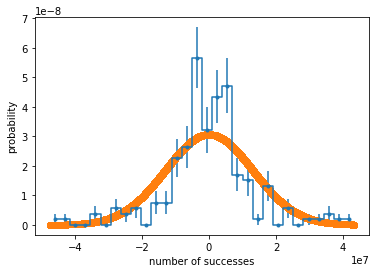

In [19]:
#Lets run the regression again
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

def linear(ix,ia,ib):
    return ia*ix+ib

var=variance(redshift)
cov=covariance(redshift,distance)
slope=cov/var
const=distance.mean()-slope*redshift.mean()
xvals = np.linspace(0,0.1,100)
yvals = []
for pX in xvals:
    yvals.append(linear(pX,slope,const))

plt.plot(xvals,yvals)
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.show()
#Now to compute the uncertainty
residuals=np.array([])
for i0 in range(len(redshift)):
    pResid=linear(redshift[i0],slope,const)-distance[i0]
    residuals = np.append(residuals,pResid)
    #residuals = np.append(residuals,pResid**2)
#This time we are going to look at a histogram of the residuals
y0, bin_edges = np.histogram(residuals, bins=30)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
norm0=len(residuals)*(bin_edges[-1]-bin_edges[0])/30.
plt.errorbar(bin_centers,y0/norm0,yerr=y0**0.5/norm0,marker='.',drawstyle = 'steps-mid')
k=np.arange(bin_edges[0],bin_edges[-1],100)
normal=stats.norm.pdf(k,0,residuals.std())


plt.plot(k,normal,'o-')
plt.xlabel("number of successes")
plt.ylabel("probability")
plt.show()

Summing: 1  numbers with mean: 4.958917357440197  and std-deviation 2.8980779462565733 2.8630322712072056


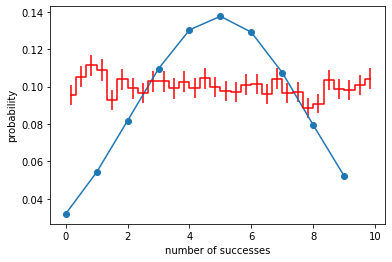

Summing: 2  numbers with mean: 10.002915040828364  and std-deviation 4.091483475288744 4.0836729650734425


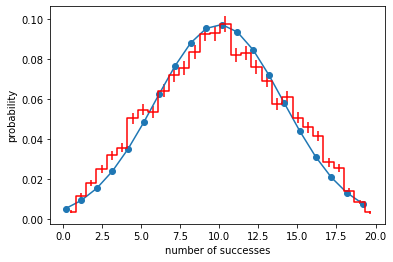

Summing: 3  numbers with mean: 14.969678172518828  and std-deviation 4.947069560935622 4.989892724172942


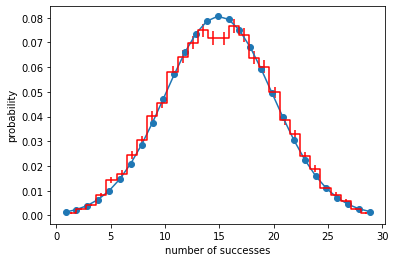

Summing: 4  numbers with mean: 19.937038641254638  and std-deviation 5.781163516506314 5.755327313186168


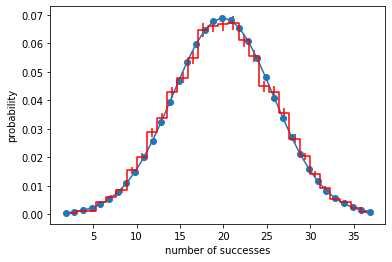

Summing: 50  numbers with mean: 249.9962958658741  and std-deviation 20.299217223017447 20.41211208190824


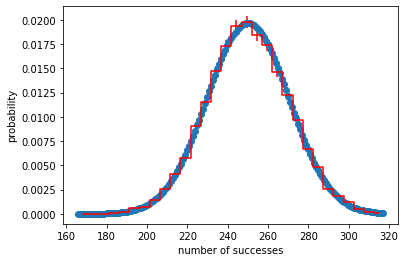

Summing: 5000  numbers with mean: 25000.299502617483  and std-deviation 203.08752781817762 204.12659066056304


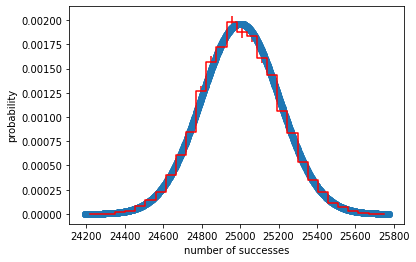

In [20]:
def normhist(iVars,iNbins=30):
    y0, bin_edges = np.histogram(iVars, bins=iNbins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm0=len(iVars)*(bin_edges[-1]-bin_edges[0])/iNbins
    plt.errorbar(bin_centers,y0/norm0,yerr=y0**0.5/norm0,drawstyle = 'steps-mid',c='red')
    return bin_edges

def plotSum(iN):
    ntoys=10000
    sums=np.array([])
    for i0 in range(ntoys):
        pToy = np.random.uniform(0,10,iN)
        sums = np.append(sums,pToy.sum())
    binrange=normhist(sums)
    k=np.arange(binrange[0],binrange[-1])
    normal=stats.norm.pdf(k,sums.mean(),sums.std())
    plt.plot(k,normal,'o-')
    plt.xlabel("number of successes")
    plt.ylabel("probability")
    print("Summing:",iN," numbers with mean:",sums.mean()," and std-deviation",sums.std(),sums.mean()/math.sqrt(3*iN))
    plt.show()
plotSum(1)
plotSum(2)
plotSum(3)
plotSum(4)
plotSum(50)
plotSum(5000)